In [48]:
import pandas as pd
import scipy.stats as ss
from scipy.stats import shapiro
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

In [2]:
users = pd.read_csv('ab_users_data.csv') # считываем данные
orders = pd.read_csv('ab_orders.csv')
products = pd.read_csv('ab_products.csv')

In [3]:
orders['product_id'] = orders.product_ids.str.split(',') # предобрабатываю данные для удобства работы
orders = orders.explode('product_id')
orders['product_id'].replace(['{', '}'], ['', ''])

0        {75
0         22
0         53
0        84}
1        {56
        ... 
4121      {9
4121      62
4121     77}
4122     {17
4122     85}
Name: product_id, Length: 13826, dtype: object

In [4]:
orders = orders.drop(columns = 'product_ids') # удаляю "визуальный шум"

In [5]:
orders['product_id'] = orders['product_id'].str.replace('{', '') # удаляю лишние символы из колонки
orders['product_id'] = orders['product_id'].str.replace('}', '')

In [6]:
orders['product_id'] = orders.product_id.astype(int) # перевожу данные в нужный формат для мерджа

In [7]:
orders_prices = orders.merge(products, on = 'product_id') 

In [8]:
order_price = orders_prices.groupby('order_id').agg({'price':'sum'}).reset_index() # считаю сумму каждого заказа

In [9]:
working_df = users.merge(order_price, on = 'order_id') # объединяю получившиеся данные для удобства работы

In [10]:
# удаляю отмененные заказы, так как буду анализировать метрики, связанные с деньгами
# а отмененные заказы денег не приносят

working_df = working_df.drop_duplicates(subset = 'order_id', keep = False) 

In [11]:
working_df.head()

,user_id,order_id,action,time,date,group,price
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0,408.7
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1,250.5
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0,310.2
5,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1,228.0
6,968,1261,create_order,2022-08-26 00:05:35.000000,2022-08-26,0,430.7


In [12]:
test_group = working_df.query('group == 1') # делю всех пользователей на два массива по группам

In [13]:
test_group['log_price'] = np.log(test_group.price) # привожу распределение сумм заказа к ± нормальному

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
control_group = working_df.query('group == 0') # делю всех пользователей на два массива по группам

In [15]:
control_group['log_price'] = np.log(control_group.price) # привожу распределение сумм заказа к ± нормальному

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


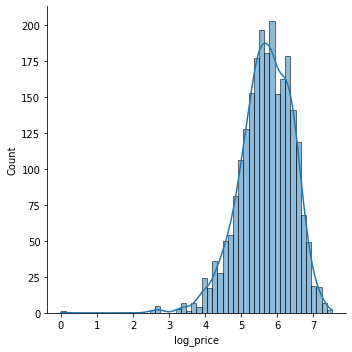

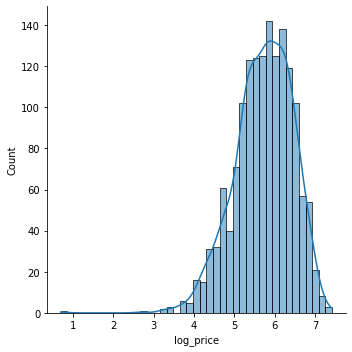

In [16]:
sns.displot(test_group.log_price, kde = True)
sns.displot(control_group.log_price, kde = True)

In [17]:
test_group.log_price.std() # считаю стандартное отклонение массива, чтобы сделать выводы о дисперсии

0.7280893936376626

In [18]:
control_group.log_price.std() # считаю стандартное отклонение массива, чтобы сделать выводы о дисперсии

0.7168363952343663

В данных удовлетворяются параметрические условия, так как по графикам можем заметить, что распределения лог-нормальны, имеют приблизительно равные дисперсии и выборки взяты из двух независимых ГС (из разных групп наблюдения за пользователями)

Воспользуемся парным t-тестом, в котором:

- $H_0$: суммы заказов в разных группах не отличаются 
- $H_1$: суммы заказов в разных группах значимо отличаются 

In [19]:
ss.ttest_ind(test_group.log_price, control_group.log_price) # p-value > 0.05, а значит у нас нет оснований отклонить нулевую гипотезу

Ttest_indResult(statistic=-1.7522118532194424, pvalue=0.07981582868828002)

В проведенном тесте метрика сумм заказов в разных группах не показала значимых различий, а значит, что алгоритм не влияет на сумму заказа. Посмотрим, на какие еще метрики он может оказывать влияние

In [20]:
# считаю количество заказов по дням для каждой из групп

orders_by_day = working_df.groupby(['date', 'group']).agg({'order_id':'count'}).reset_index()

In [21]:
orders_control = orders_by_day.query('group == 0').reset_index() # делю всех пользователей на два массива по группам

In [22]:
orders_test = orders_by_day.query('group == 1').reset_index() # делю всех пользователей на два массива по группам

В данных не удовлетворяются параметрические условия

Воспользуемся U-тест Манна-Уитни, в котором:

- $H_0$: количество заказов в разных группах не отличаются 
- $H_1$: количество заказов в разных группах значимо отличаются 

In [23]:
ss.mannwhitneyu(orders_test.order_id, orders_control.order_id) # p-value < 0,05 позволяет нам отвергнуть нулевую гипотезу

MannwhitneyuResult(statistic=162.0, pvalue=0.00352648665061584)

In [24]:
orders_diff = orders_test.order_id - orders_control.order_id

In [25]:
orders_diff # видим, что в тестовой группе количество заказов всегда больше, чем в контрольной

0      60
1      81
2     111
3     114
4      55
5      55
6      56
7      62
8      78
9      54
10     32
11     11
12     40
13     46
Name: order_id, dtype: int64

Проведя U-тест Манна-Уитни, мы получили значимые отличия в количествах заказов по дням в двух различных группах

Так как в тестовой группе заказов всегда больше, чем в контрольной, можно утверждать, что введение нового алгоритма значимо влияет на увеличение количества заказов.


После прочтения статьи от Авито на Хабре немного перестал "доверять" U - тесту и решил провести еще и bootstrap анализ, чтобы удостовериться в правильности своего решения

In [102]:
# формирую датафрейм для контрольной группы

control_df = orders_by_day.query("group == 0")

In [103]:
# формирую датафрейм для тестовой группы

test_df = orders_by_day.query("group == 1")

Рассчитаем доверительный интервал для разницы медиан в тестовой и контрольной группах:

In [112]:
median_diff = []

for i in range(10000):
    sample_data_control = control_df.sample(frac=1, replace=True)
    sample_median_control = sample_data_control.order_id.median()
    
    
    sample_data_test = test_df.sample(frac=1, replace=True)
    sample_median_test = sample_data_test.order_id.median()
    
    sample_median_diff = sample_median_test - sample_median_control
    median_diff.append(sample_median_diff)

In [113]:
pd.Series(median_diff).quantile(0.975)

105.01249999999982

In [114]:
pd.Series(median_diff).quantile(0.025)

20.5

Что и требовалось доказать, доверительный интервал для разности медиан не включает в себя 0 и положителен, а значит, что медианы отличаются статистически значимо и эти различия положительны.

## Вывод:

Считаю, что алгоритм следует все-таки внедрить в работу приложения, так как положительная динамика метрики все же есть, хоть и дополнительной выручки алгоритм не приносит (доказано при проведении парного t-теста средней суммы заказа). С помощью алгоритма можно добиться увеличения количества заказов, повысить средний чек путем каких-либо дополнительных алгоритмов или промокодов, а за счет этого вырастет и выручка. В общем, напрямую на выручку бизнеса алгоритм не выполняет, но позволяет значительно продвинуться к успеху.